# Introduction

また、verdi process listを見るとわかるとおり、WorkChain名やCalculation名が表示されるので、
何を行ったのかわからなくなる。

何を行ったのか知る方法は、
1. どういう値の入力で計算を実行したのかを検索する。
1. あとで人間がわかるようにlabelをつけておく。

である。AiiDAの元々の意図は二番目を用いる手法だっただろう。しかし、人間にはわかりにくい。


labelをつけて、更に、AiiDAのデータは階層構造がないので（擬似的に）階層構造をつくりまとめる方法には以下がある。


1. group
2. nodeのextra

これらでnodeのlabelづけを行う。

# nodeのextra

nodeのextraによるlabel付けを行う。

In [1]:
from aiida.plugins import DataFactory
import aiida
aiida.load_profile()

Profile<uuid='aaaefae20eac49f892e60b4593a470e3' name='quicksetup'>

In [2]:
from aiida.engine import calcfunction,workfunction, WorkChain, ToContext, submit,run,while_
from aiida.orm import Str,Float, Dict, load_node
import numpy as np
from aiida.plugins import DataFactory, WorkflowFactory
import time

In [3]:
if True:
    # 再計算をチェックしないので、計算されていたら削除しておく。
    # verdi node delete 相当
    from aiida.orm import QueryBuilder
    from aiida.tools import delete_nodes

    qb = QueryBuilder()
    qb.append(WorkChain, filters={"extras":{"has_key":"scale"}})

    node_pks_to_delete = []
    for subpath in qb.all(flat=True):
        print("subpath",subpath, subpath.base.extras.all["scale"])
        node_pks_to_delete.append(subpath.pk)
    if len(node_pks_to_delete)>0:
        _, was_deleted = delete_nodes(node_pks_to_delete, dry_run=False,create_forward=True, call_calc_forward=True, call_work_forward=True)
        if was_deleted:
            print("deleted", node_pks_to_delete)

subpath uuid: 6432cafe-7633-4f63-a353-3738ddcfc5ae (pk: 10459) (aiida.workflows:structool.rescaledvolume) scale1
subpath uuid: 7098e6e7-fd75-4c07-b146-711d3735385f (pk: 10483) (aiida.workflows:structool.rescaledvolume) scale1
subpath uuid: 4b009192-9c92-43d5-8671-9c38f4fdf694 (pk: 10507) (aiida.workflows:structool.rescaledvolume) scale2
subpath uuid: 124d5530-5c8e-4a7f-a0a6-22a46be90fb7 (pk: 10531) (aiida.workflows:structool.rescaledvolume) scale2


12/04/2024 10:35:32 PM <17814> aiida.delete: [REPORT] 68 Node(s) marked for deletion
12/04/2024 10:35:32 PM <17814> aiida.delete: [REPORT] Starting node deletion...
12/04/2024 10:35:32 PM <17814> aiida.delete: [REPORT] Deletion of nodes completed.


deleted [10459, 10483, 10507, 10531]


In [4]:
# define inputs
def define_inputs(elementstr, factor_list =  [0.98, 0.99, 1.0, 1.1, 1.2]):
    element = Str(elementstr)
    element.store()
    print("element.pk",element.pk)

    ArrayData = DataFactory('core.array')
    factor_array = ArrayData()
    factor_array.set_array("vector",np.array(factor_list))
    return element, factor_array
    
# run
element, factor_array = define_inputs("Si")
import os
absolute_path = Str(os.getcwd())

element.pk 10901


In [5]:
rescaledstructuresvolume = WorkflowFactory("structool.rescaledvolume")
builder = rescaledstructuresvolume.get_builder()
builder.element=element
builder.factor_array=factor_array
builder.absolute_path = absolute_path
future = submit(builder)
future.base.extras.set("scale","scale1") # scale:scale1がextrasに付加される。
print("extras", future.base.extras.all)

extras {'scale': 'scale1', '_aiida_hash': '357c58cf47e7ef5f25a2f77963a4a97c2424807b476b4453fe20d8efd13f231f'}


In [6]:
from icecream import ic
while not future.is_finished:
    ic(future.is_finished)
    time.sleep(2)
ic(future.is_finished_ok)

ic(future.outputs.volume_avg.value)

ic| future.is_finished: False
ic| future.is_finished: False
ic| future.is_finished_ok: True
ic| future.outputs.volume_avg.value: 47.821088881098


47.821088881098

In [7]:
pk = future.outputs.volume_avg.pk
pk

10925

Success: Output written to `10925.dot.pdf`


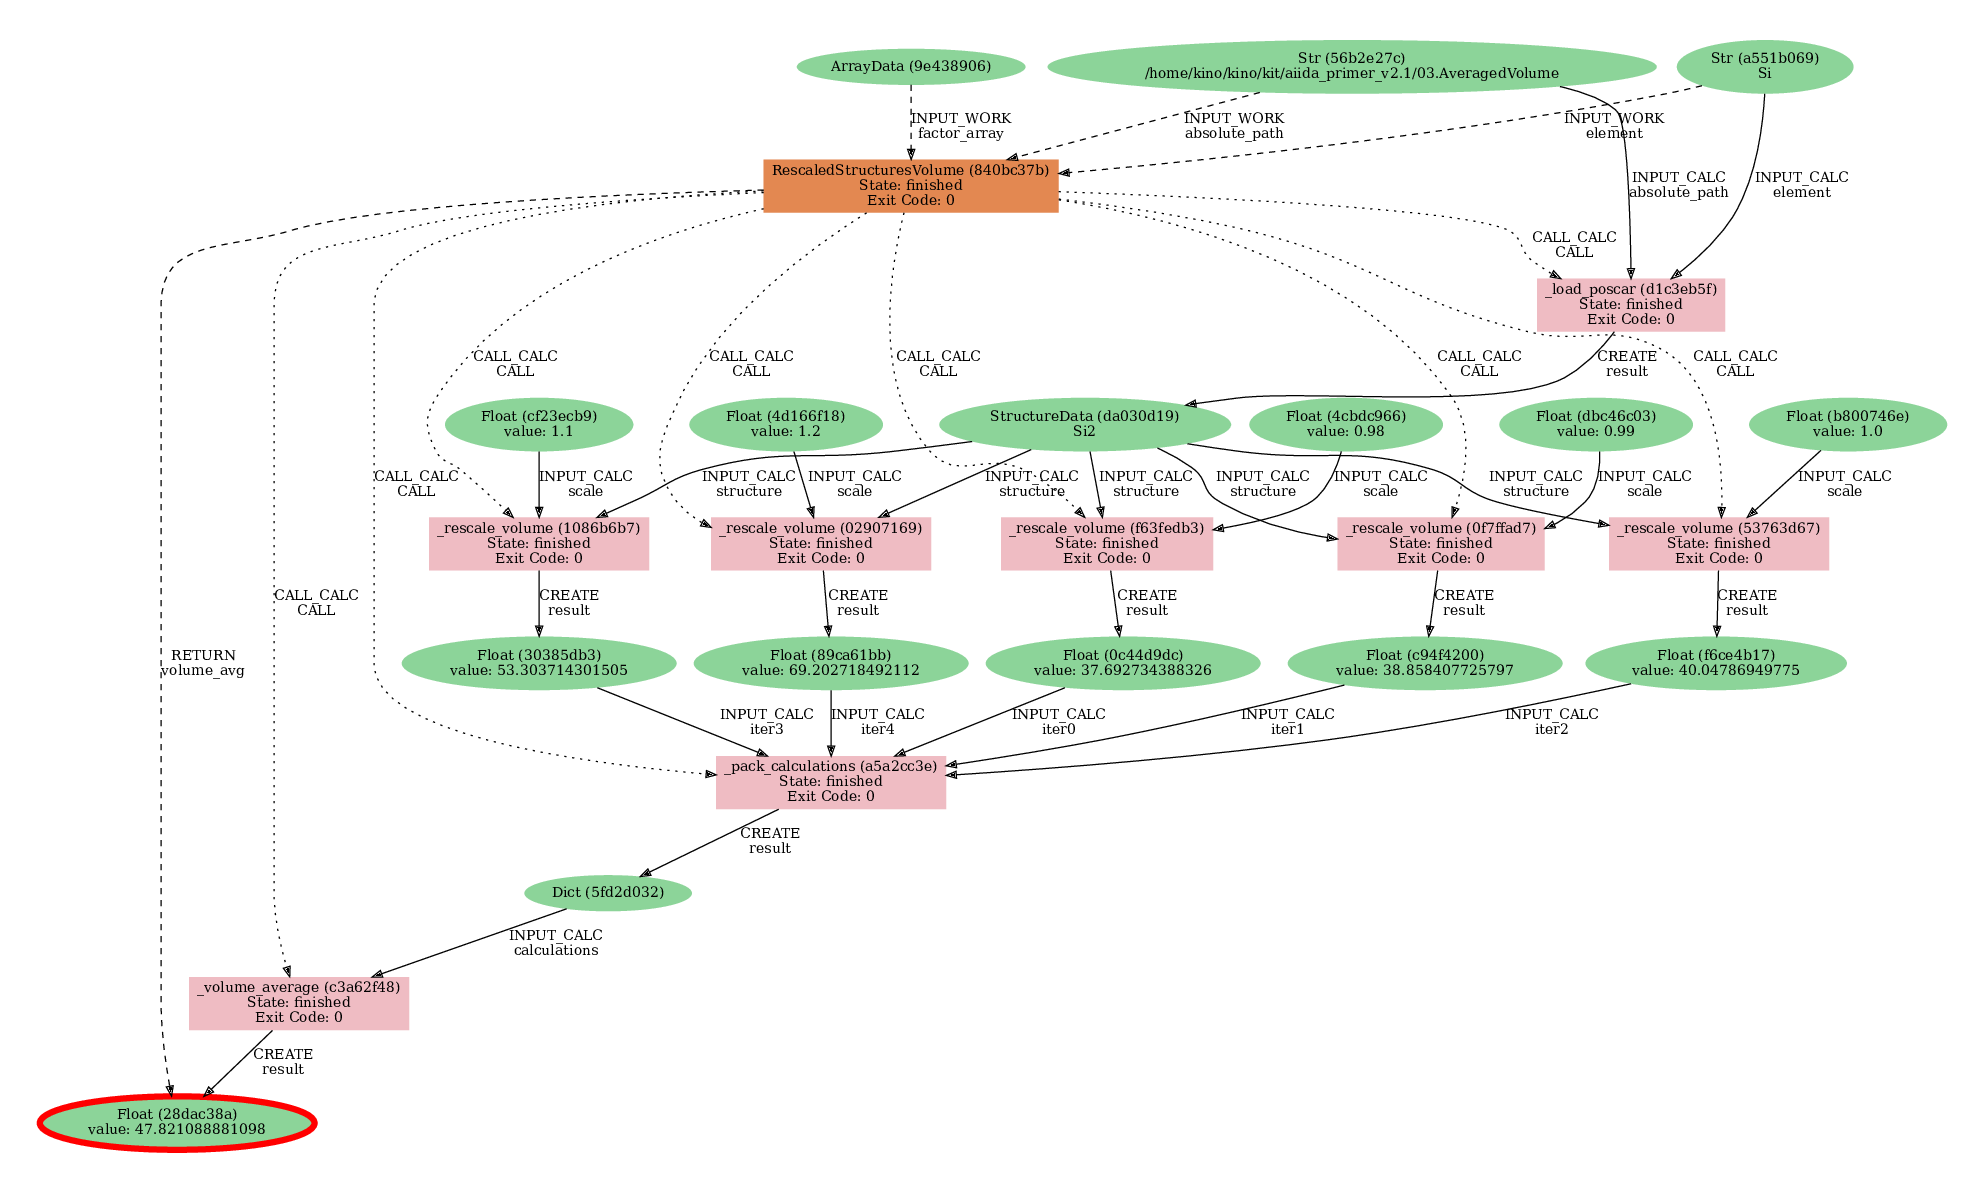

In [8]:
import subprocess
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

## change elements

In [9]:
element, factor_array = define_inputs("Ge")
rescaledstructuresvolume = WorkflowFactory("structool.rescaledvolume")
builder = rescaledstructuresvolume.get_builder()
builder.element=element
builder.factor_array=factor_array
builder.absolute_path = absolute_path
future = submit(builder)
future.base.extras.set("scale","scale1") # scale:scale1がextrasに付加される。
ic(future.base.extras.all)

element.pk 10926


ic| future.base.extras.all: {'_aiida_hash': 'e7324a0b1991a35b20798d395d2f526ee087a76ea089b884e566dad59adc7b2d',
                             'scale': 'scale1'}


{'scale': 'scale1',
 '_aiida_hash': 'e7324a0b1991a35b20798d395d2f526ee087a76ea089b884e566dad59adc7b2d'}

## change element and factor list

 factor_listが98%,98%,100%, 110%, 120%である。
間違っており、98%,98%,100%, 101%, 102%としたい。

In [10]:
element, factor_array = define_inputs("Si",factor_list =  [0.98, 0.99, 1.0, 1.01, 1.02])
rescaledstructuresvolume = WorkflowFactory("structool.rescaledvolume")
builder = rescaledstructuresvolume.get_builder()
builder.element=element
builder.factor_array=factor_array
builder.absolute_path = absolute_path
future = submit(builder)
future.base.extras.set("scale","scale2")

element.pk 10929


In [11]:
element, factor_array = define_inputs("Ge",factor_list =  [0.98, 0.99, 1.0, 1.01, 1.02])
rescaledstructuresvolume = WorkflowFactory("structool.rescaledvolume")
builder = rescaledstructuresvolume.get_builder()
builder.element=element
builder.factor_array=factor_array
builder.absolute_path = absolute_path
future = submit(builder)
future.base.extras.set("scale","scale2")

element.pk 10933


Success: Output written to `10936.dot.pdf`


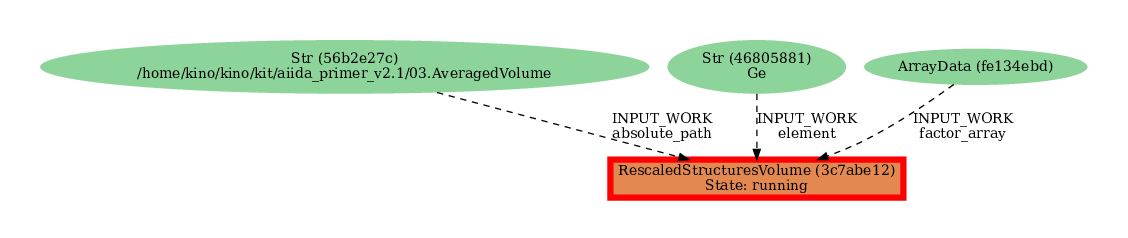

In [12]:
import subprocess
pk = future.pk
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

factor_arrayは共通なので、factor_arrayから書くと一つのグラフに見える。

Success: Output written to `10935.dot.pdf`


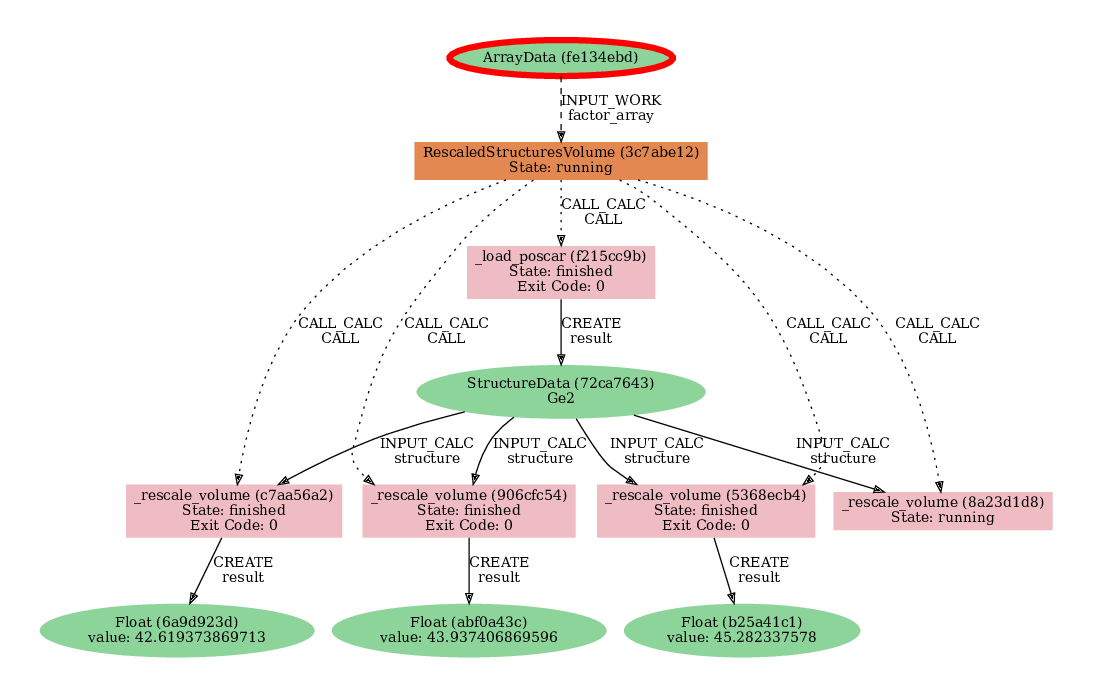

In [13]:
import subprocess
pk = factor_array.pk
cmd = "verdi node graph generate {}".format(pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(pk))

# ノード検索
extras.scaleを検索する。

In [14]:
from aiida.orm import QueryBuilder
qb = QueryBuilder()
action = 1
if action==1:
    qb.append(WorkChain, filters={"extras":{"has_key":"scale"}})
else:
    qb.append(WorkChain, filters={"extras.scale":{"==":"scale1"}})

for subpath in qb.all(flat=True):
    print("subpath",subpath, subpath.base.extras.all["scale"])

subpath uuid: 840bc37b-9c65-4584-bf44-c3d06ae892ff (pk: 10904) (aiida.workflows:structool.rescaledvolume) scale1
subpath uuid: 344c8380-147d-4358-8701-76f218d822d7 (pk: 10932) (aiida.workflows:structool.rescaledvolume) scale2
subpath uuid: af455bd9-e630-4a7f-82d2-2125a1b8b2b5 (pk: 10928) (aiida.workflows:structool.rescaledvolume) scale1
subpath uuid: 3c7abe12-91bf-48b5-b849-e2c5daf360bc (pk: 10936) (aiida.workflows:structool.rescaledvolume) scale2


rescaledstructuresvolumeはWorkChainの子クラスなので、この場合はWorkChainとしても動作する。

In [15]:
rescaledstructuresvolume = WorkflowFactory("structool.rescaledvolume")
from aiida.orm import QueryBuilder
qb = QueryBuilder()
action = 1
if action==1:
    qb.append(rescaledstructuresvolume, filters={"extras":{"has_key":"scale"}})
else:
    qb.append(rescaledstructuresvolume, filters={"extras.scale":{"==":"scale1"}})

for subpath in qb.all(flat=True):
    print("subpath",subpath, subpath.base.extras.all["scale"])

subpath uuid: 840bc37b-9c65-4584-bf44-c3d06ae892ff (pk: 10904) (aiida.workflows:structool.rescaledvolume) scale1
subpath uuid: 344c8380-147d-4358-8701-76f218d822d7 (pk: 10932) (aiida.workflows:structool.rescaledvolume) scale2
subpath uuid: af455bd9-e630-4a7f-82d2-2125a1b8b2b5 (pk: 10928) (aiida.workflows:structool.rescaledvolume) scale1
subpath uuid: 3c7abe12-91bf-48b5-b849-e2c5daf360bc (pk: 10936) (aiida.workflows:structool.rescaledvolume) scale2


# グラフノード探索
例えば、ある条件を満たすノードの出力を用いるノードが異なる条件を満たす、という探索を行う。



## 一つ前のノード条件の付加
---------
![](fig/relation_search1.png)

-----------

nodeは図(a)のようにWorkChain, Str, ArrayData, ...などからなりたつ。

図(b)で示すように
1. 一つ前のノードがStr("Si")かつ、
1. rescaledstructuresvolumeのextras.scale == "scale1"の

rescaledstructuresvolumeを探す。

検索時にノードにtagをつけて,with_coming=tag付けしたノード、でAND探索を行う。

In [16]:
from aiida.orm import QueryBuilder

rescaledstructuresvolume = WorkflowFactory("structool.rescaledvolume")
# 上を用いて検索した結果は、fromでimportした結果と異なる。

qb = QueryBuilder()

action = 1
if action==1:
    qb.append(Str, filters={"attributes.value":"Si"}, tag="step1")
else:
    qb.append(Str, filters={"or" :
                            [{"attributes.value":"Si"},{"attributes.value":"Ge"}]},
              tag="step1")

qb.append(rescaledstructuresvolume, with_incoming="step1", 
          filters={"extras.scale":{"==":"scale1"}})

for subpath in qb.all(flat=True):
    print("subpath",subpath.base.attributes.all, subpath.inputs.element)

subpath {'sealed': True, 'version': {'core': '2.6.2'}, 'exit_status': 0, 'process_label': 'RescaledStructuresVolume', 'process_state': 'finished', 'metadata_inputs': None, 'stepper_state_info': '2:volume_agv'} uuid: a551b069-3306-45fb-8030-013f78030f20 (pk: 10901) value: Si


出力がWorkChain nodeとなる。

## 一つ後のノード条件の付加
逆に、図(c)のように
1. rescaledstructuresvolumeでextras.scale == "scale1"かつ
1. Str("Si") となるノード

を検索する。

In [17]:
from aiida.orm import QueryBuilder
rescaledstructuresvolume = WorkflowFactory("structool.rescaledvolume")

qb = QueryBuilder()

action = 1
if action==1:
    qb.append(rescaledstructuresvolume, filters={"extras.scale":{"==":"scale1"}}, tag="step1")
else:
    qb.append(rescaledstructuresvolume, filters={"extras":{"has_key":"scale"}}, tag="step1")
    
qb.append(Str, with_outgoing="step1", filters={"attributes.value":"Si"})

for subpath in qb.all(flat=True):
    print("subpath",subpath.base.attributes.all)

subpath {'value': 'Si'}


この場合は出力はStr nodeとなる。

## comment

### comment1
この例ではfactor_arrayは共通なのでのfactor_arrayのextraにlabelを付けておくやり方もある。
extra labelは後から付けられる。

In [18]:
future.base.extras.set("comment","done")
future.store()
future.base.extras.all

{'scale': 'scale2',
 'comment': 'done',
 '_aiida_hash': '01a107d2206092283052f23da3b1c5c01c7ff11e8494a14ca4385c929b93d28e'}

ただ、future nodeを保存してあるか、別途探索する必要がある。

このprimerでは似たことを何度も行っている。
予めextrasを作っておかないで、
- Str(attributes.value="Si") --> rescaledstructuresvolume

を検索するとこうなる。

In [19]:
from aiida.orm import QueryBuilder
rescaledstructuresvolume = WorkflowFactory("structool.rescaledvolume")

qb = QueryBuilder()

qb.append(Str, filters={"attributes.value":"Si"}, tag="step1")
qb.append(rescaledstructuresvolume, with_incoming="step1")

for subpath in qb.all(flat=True):
    print(subpath.pk, subpath.outputs.volume_avg)

8010 uuid: d8a5863c-fa7b-4343-a245-7d2bfcb0d848 (pk: 8031) value: 47.821088881098
8032 uuid: 37f3db8b-45f0-49d6-bcfd-f95d8b2e991f (pk: 8053) value: 47.821088881098
8904 uuid: 4f1503f1-7f49-4ef4-9b40-c32afa3a4e2a (pk: 8925) value: 47.821088881098
8931 uuid: 4aef5873-1bb7-4284-ae72-670c60cd7ecf (pk: 8981) value: 40.071898219448
10315 uuid: 6fefa455-2943-4515-9d1d-0f32b6779278 (pk: 10336) value: 47.821088881098
8706 uuid: 380819d3-0724-4506-9c97-262fe0779e78 (pk: 8727) value: 47.821088881098
8733 uuid: 485c6c8c-b07b-45a9-a5de-26bee5694d6c (pk: 8783) value: 40.071898219448
8803 uuid: fccb7165-5abb-427e-b6df-d5b46bdcd6a9 (pk: 8824) value: 47.821088881098
8851 uuid: 19aa3a15-16dd-41cc-afc6-da847bd0e24d (pk: 8873) value: 40.071898219448
10857 uuid: 426b3e59-a513-48b0-9771-96720bfc5f2d (pk: 10878) value: 47.821088881098
10879 uuid: 3773088d-db9f-4ee4-a687-8fcf1b82e4be (pk: 10900) value: 47.821088881098
10337 uuid: 5fcf53f7-bddb-494a-b814-5bd7ef59b853 (pk: 10358) value: 47.821088881098
10904 uu

NotExistentAttributeError: Node<10932> does not have an output with link label 'volume_avg'

- Str(attributes.value="Si") --> rescaledstructuresvolume --> Float

を検索するとこうなる。

In [ ]:
from aiida.orm import QueryBuilder
rescaledstructuresvolume = WorkflowFactory("structool.rescaledvolume")

qb = QueryBuilder()

qb.append(Str, filters={"attributes.value":"Si"}, tag="step1")
qb.append(rescaledstructuresvolume, with_incoming="step1", tag="step2")
qb.append(Float, with_incoming="step2")

for subpath in qb.all(flat=True):
    print(subpath.pk, subpath.base.attributes.all)

inputsだけでは検索しにくい場合は予めextrasを付加したほうが良い。

### comment2

https://aiida.readthedocs.io/projects/aiida-core/en/latest/topics/database.html?highlight=QueryBuilder

- with_incomming, with_outgoingを多数書いたり、
- qb.append(WorkChain,...)のように探索条件を書かないとWorkChainの全選択になり、一つ以上のノードを空けて探索条件を書くなどして、

もっと複雑なグラフ検索にすることが可能。



- projectでattributeの一部だけ出力することも可能。